In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
# %matplotlib qt
# %matplotlib inline
import pickle
calibration_flag = 0
report_images = 0 

In [2]:
def showImg(img):
    plt.imshow(img)
    plt.show()

## Find Chessboard Corners

In [3]:
if calibration_flag == 1:
    # Set numb er of chessboard points
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)


## Create mtx and dist matrices to Calibrate Camera

In [4]:
if calibration_flag == 1:
    # Test undistortion on an image
    img = cv2.imread('test_images/test1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test1_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    # pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
    
    ## CALIBRATION IMAGE FOR REPORT REQUIRED
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

## Generate Image for Report

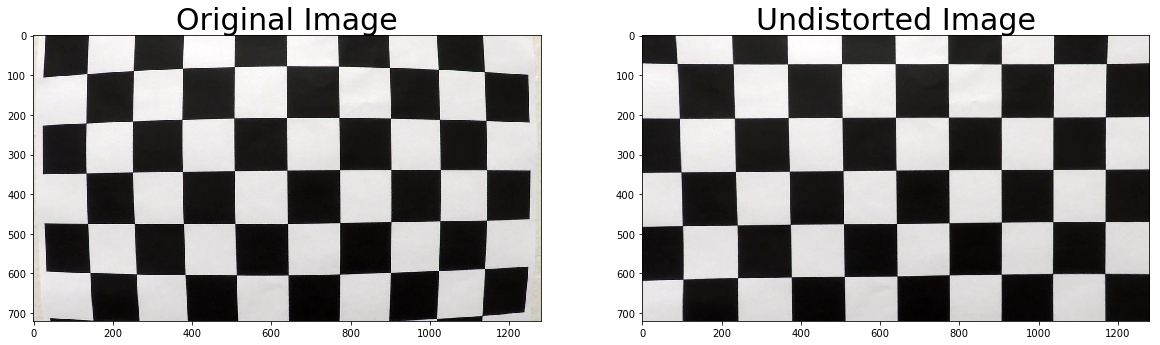

In [7]:
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']


# Use Chessboard
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

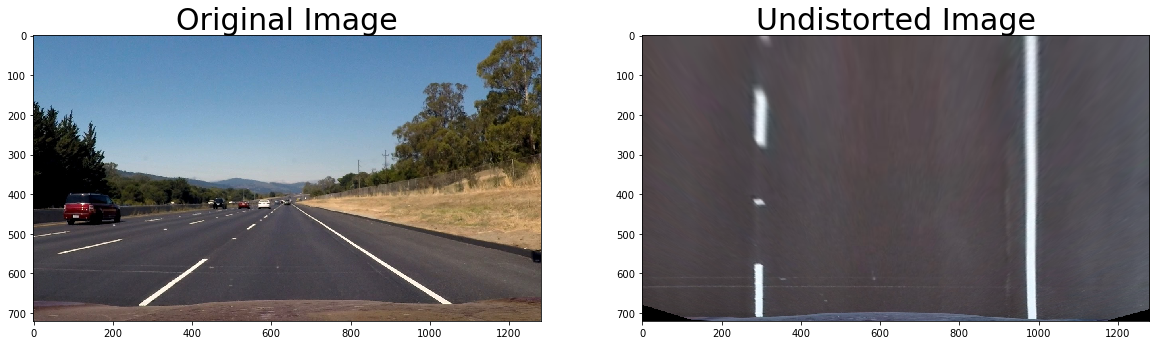

In [8]:
img = cv2.imread('test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])
undist = cv2.undistort(img, mtx, dist, None, mtx)
undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
img_size = (gray.shape[1], gray.shape[0])

# Working for full sized image
src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)]) 

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, img_size)

# dst, _ = reproject(dst, nx, ny, mtx, dist )
undist = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Colour & Gradient Thresholding

In [46]:
##################################################
# Sobel Threshold
##################################################
def abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(0, 255)):  
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


##################################################
# Magnititude Thresholding - USEFUL CODE
##################################################
def mag_thresh(img, sobel_kernel=5, mag_thresh=(100, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


##################################################
# Gradient Direction for Feature Detection - USEFUL CODE
##################################################
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


##################################################
# Colour Spaces
##################################################
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    
    # Convert to HLS colour space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    #mask[mask == 255] = 1
    return mask
    
def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    #mask[mask == 255] = 1
    return mask

##################################################
# My Pipeline
##################################################
def imagePipeline(image):
    # Sobel kernel size
    ksize = 5 
    sx_thresh = (20, 255)
    sy_thresh = (20, 255)
    
    image = np.copy(image)
    
    # Create Masks
    mask_yellow = select_yellow(image)
    mask_white = select_white(image)
    # Apply Masks to create new layers
    yellow = cv2.bitwise_and(image,image,mask=mask_yellow)
    white = cv2.bitwise_and(image,image,mask=mask_white)
    # Combine
    image = cv2.addWeighted(yellow, 1, white, 1, 0)

    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(20, 255))
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(60, 255)) 
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=(1.4, np.pi/2)) # Value is in radians div 180
    # Bonus
    hls_binary = hls_select(image, thresh=(90, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary==1)] = 1

    return combined

# Testing
# image = cv2.imread('test_images/test2.jpg')
# img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# img = imagePipeline(img)
# img, _ = reproject(img, nx, ny, mtx, dist )  

# img2 = imagePipeline(image)
# img2, _ = reproject(img2, nx, ny, mtx, dist ) 
# plotResult(img, img2)

## Plotting Function for Testing

In [47]:
def plotResult(original, new):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        cmap1=None
    else:
        cmap1='gray'
        
    ax1.imshow(original, cmap=cmap1)
    ax1.set_title('Original Image', fontsize=40)
    
    if len(new.shape) == 3:
        new = cv2.cvtColor(new, cv2.COLOR_BGR2RGB)
        cmap2=None
    else:
        cmap2='gray'
        
    ax2.imshow(new, cmap=cmap2)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Tranform Image to Top View

In [48]:
def reproject(image, nx, ny, mtx, dist ):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if image.shape == 3:
        # Colour
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
        img_size = (gray.shape[1], gray.shape[0])
    else:
        # B&W
        img_size = (image.shape[1], image.shape[0])
        
    # Working for full sized image
    src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
    dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)]) 

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped, Minv

## Lane finding with convolutions

In [49]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def findLanes(warped):
    # window settings
    window_width = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    pts_l = []
    pts_r = []
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # Make some empty lists to store window centroids

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
       

    return output, l_points, r_points

In [75]:
def slidingWindow(binary_warped):
    global left_lane
    global right_lane
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Do some smoothing
    # Make best fit
    smoothing = 0.6
    
    if type(left_lane.current_fit ) == list:
        # first time through
        left_lane.best_fit = left_fit
        right_lane.best_fit = right_fit
    else:     
        left_lane.best_fit = smoothing*left_fit + (1-smoothing)*left_lane.current_fit
        right_lane.best_fit = smoothing*right_fit + (1-smoothing)*right_lane.current_fit

    # Update current fit
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print('left curve',left_curverad, 'm', 'right curve', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    
    ####
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    return result, left_curverad, right_curverad, [left_fitx, right_fitx, ploty]


## Measure Curvature

In [50]:
# def measureCurve(leftx, rightx):  
def measureCurve(lx, ly, rx, ry):    
    global left_lane
    global right_lane
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ly, lx, 2)    
    right_fit = np.polyfit(ry, rx, 2)
    
    ## Do some smoothing
    # Make best fit
    smoothing = 0.6
    
    if type(left_lane.current_fit ) == list:
        # first time through
        left_lane.best_fit = left_fit
        right_lane.best_fit = right_fit
    else:     
        left_lane.best_fit = smoothing*left_fit + (1-smoothing)*left_lane.current_fit
        right_lane.best_fit = smoothing*right_fit + (1-smoothing)*right_lane.current_fit

    # Update current fit
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit
    
    # Generate points for the 2nd order poly
    left_fitx = left_fit[0]*ly**2 + left_fit[1]*ly + left_fit[2]
    right_fitx = right_fit[0]*ry**2 + right_fit[1]*ry + right_fit[2]
    
    ## Convert curvature to metres
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    
    y_eval = np.max(720)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ly*ym_per_pix, lx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ry*ym_per_pix, rx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
  
    return round(left_curverad, 1), round(right_curverad, 1), [left_fitx, right_fitx], [left_fit, right_fit]

## Get the X,Y for Reprojection

In [51]:
# # Get points
# %matplotlib qt
# image = cv2.imread('test_images/straight_lines1.jpg')
# showImg(image)

## Identify the x and y positions of all nonzero pixels in the image

In [52]:
def img2XY(img):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

## Function Plots the green carpet on the lane of the original Image

In [61]:
def greenRoad(undist, warped, left_fitx, right_fitx, ploty, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result



In [53]:
def carpetPlotter(undist, warped, left_fitx, ly, right_fitx, ry, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ly]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ry])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result

In [54]:
def zipPoints(left_fitx, ly):
    l_pts = []
    for x,y in zip(left_fitx, ly):
        l_pts.append((x, y))
    
    l_pts = np.array(l_pts, dtype = np.int32) 

    return l_pts

In [55]:
def reportPlotter(undist, warped, left_fitx, ly, right_fitx, ry, Minv ):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ly]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ry])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the Polynomials onto the warped blank image
    l_pts = zipPoints(left_fitx, ly)
    r_pts = zipPoints(right_fitx, ry)
    
    color = (255,0,0) # blue
    line_width = 15
    cv2.polylines(color_warp, [l_pts], False, color, thickness=line_width, lineType=cv2.CV_AA)
    color = (0,0,255) # red
    cv2.polylines(color_warp, [r_pts], False, color, thickness=line_width, lineType=cv2.CV_AA)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 2, 0)
    
    write_name = 'assets/polyplot_'+str(idx)+'.jpg'
    cv2.imwrite(write_name, result )


In [56]:
def onesTo255(img):
    # Convert 1's to 255
    img_bw = np.zeros_like(img)
    img_bw[img == 1] = 255
    img_bw = np.array(img_bw, dtype = np.uint8) 
    
    return img_bw

## ESTIMATE THE OFFSET OF THE CAR FROM CENTRE

In [69]:
def getOffset(lx, rx):
    y_eval = 720
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    
    leftPos = lx[-1]
    rightPos = rx[-1]
    carDatum = 640
    
    laneWidth = rightPos - leftPos
    laneCentre = leftPos + laneWidth / 2
    # Offset w.r.t image axis
    offset_m = (carDatum - laneCentre) * xm_per_pix
    
    return round(offset_m, 1)

In [58]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
   
left_lane = Line()
right_lane = Line()        

## FLOW CONTROL

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## My Lane Finding Pipeline

In [70]:
def process_image(image):
    
    # Set number of chessboard points
    nx = 9
    ny = 6
    
    # Undistort
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Colour and Gradient Thresholding
    img = imagePipeline(image) 
    
    warped, Minv = reproject(img, nx, ny, mtx, dist )   
    
    result, left_curverad, right_curverad, fits = slidingWindow(warped)
    left_fitx = fits[0]
    right_fitx = fits[1]
    ploty = fits[2]

    curveText = 'Curve Radii => Left ' + str(left_curverad) + 'm, Right ' + str(right_curverad) + 'm'
    
    # NOW ESTIMATE THE OFFSET OF THE CAR FROM CENTRE
    offset_m = getOffset(left_fitx, right_fitx)
    offsetText = 'Offset of vehicle is ' + str(offset_m) + 'm'
    
    # Plot the green carpet in lane
    carpet = greenRoad(image, warped, left_fitx, right_fitx, ploty, Minv )
    
    # Put text on frame
    colour = (0, 0, 0)
    thickness = 2
    scale = 0.7
    cv2.putText(carpet, curveText, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, scale, colour, thickness)
    cv2.putText(carpet, offsetText, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, scale, colour, thickness)

    return carpet

## Finding Lines (Sliding window)

## Test bed

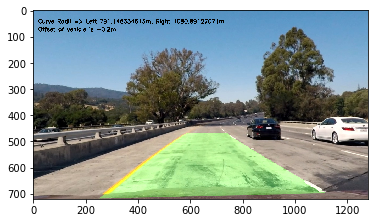

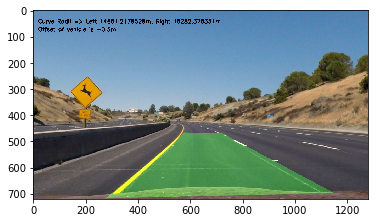

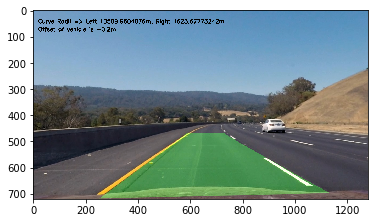

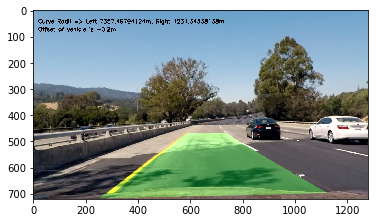

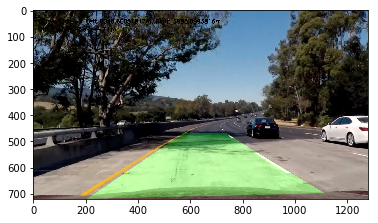

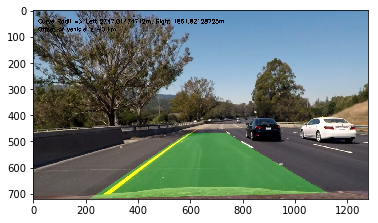

In [73]:
%matplotlib inline
images = glob.glob('test_images/test*.jpg')

# Load Pickled mtx, dist and M for image calibration and transformation
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

# Set number of chessboard points
nx = 9
ny = 6

# Step through the list of images
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    carpet = process_image(image)
    showImg(carpet)
    #showImg(cv2.cvtColor(carpet, cv2.COLOR_BGR2RGB))
    # plotResult(carpet, lanes)
    
    # Save to file
    # write_name = 'assets/straight_carpet_'+str(idx)+'.jpg'
    # cv2.imwrite(write_name, carpet )
    
    # Save to file
    # write_name = 'out/lanes_'+str(idx)+'.jpg'
    # cv2.imwrite(write_name, lanes )

## Test on Videos!

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Load Pickled mtx, dist and M for image calibration and transformation
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

## Project Video

In [76]:
output = 'project_video_output.mp4'
# A short subclip
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:55<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 16s, sys: 1min 41s, total: 7min 58s
Wall time: 6min 56s


In [79]:
output = 'challenge_output.mp4'
# A short subclip
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)